In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [2]:
# load data
path = ''
df = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [3]:
# a simple function to clean text data 
import re 
from string import punctuation 
def text_cleaning(text):
    # Clean the text data

    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
        
    # Return a list of words
    return(text)

In [4]:
#clean the train and test data
df["comment"] = df["comment"].apply(text_cleaning)
test["comment"] = test["comment"].apply(text_cleaning)

In [5]:
df.head()

,train_id,comment,sentiment
0,bbe0f441-b2fc-461a-9618-e3a7eb9cb6b7,habari telecom1 tz naomba kujua kama kuna hud...,-1
1,81b3b16d-8bf0-4d46-9b68-d7ffb078d108,telecom3 tanzania hivi telecom3 mnatuchukulia...,-1
2,f4785623-6bb9-49de-b905-25911a66f1d3,telecom2 wamupunguza vifurushi vya internet k...,0
3,0ec5ec2b-0811-4b1d-be70-9cc0c137159a,telecom2 kwenye huduma1 nimewakubali sana sem...,-1
4,40082169-ebd0-4ca9-b0d3-c46ac949e034,idrissultan vip kuhusu hawa mzee umefikia...,0


In [6]:
X = df['comment']
y = df['sentiment'].to_numpy()

In [7]:
# Tokenize the comments
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment'])  
X = tokenizer.texts_to_sequences(df['comment']) 

# Pad the sequences 
max_sequence_length = 100  
X = pad_sequences(X, maxlen=max_sequence_length)

# Convert the sentiment labels to one-hot encoded vectors
y = np.zeros((len(df), 3))  # 3 represents the number of sentiment classes
sentiment_mapping = {-1: 0, 0: 1, 1: 2}  
for i, sentiment in enumerate(df['sentiment']):
    index = sentiment_mapping[sentiment]
    y[i, index] = 1


In [8]:
split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(split_ratio * len(df))

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

In [9]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1706112   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,838,083
Trainable params: 1,838,083
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
79/79 [==============================] - 62s 685ms/step - loss: 0.9958 - accuracy: 0.4840 - val_loss: 0.9512 - val_accuracy: 0.5488
Epoch 2/3
79/79 [==============================] - 33s 416ms/step - loss: 0.8214 - accuracy: 0.6533 - val_loss: 0.9544 - val_accuracy: 0.5584
Epoch 3/3
79/79 [==============================] - 34s 434ms/step - loss: 0.4092 - accuracy: 0.8551 - val_loss: 1.2383 - val_accuracy: 0.5072


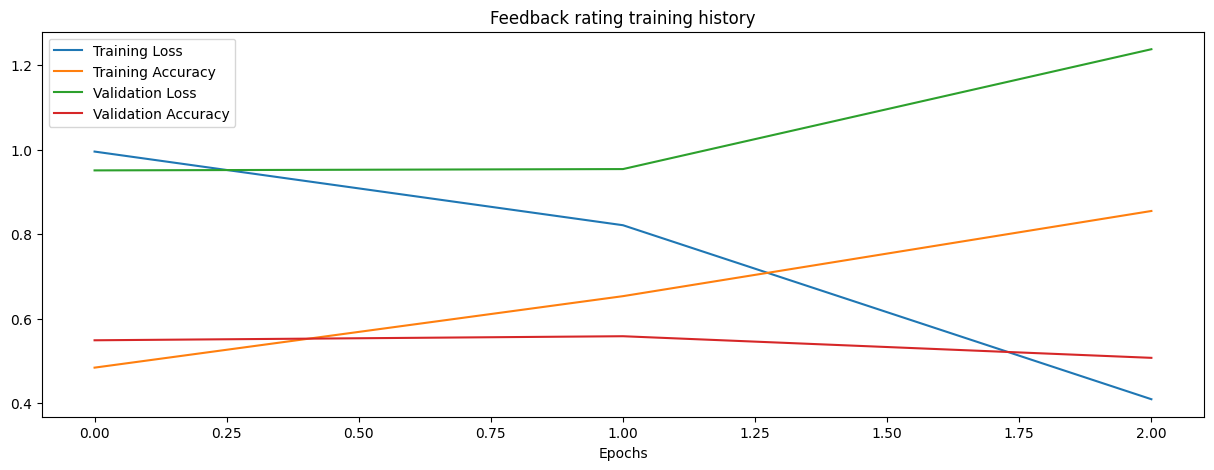

In [11]:
plt.figure(figsize=(15,5))
plt.title("Feedback rating training history")

plt.xlabel("Epochs")

x = history.epoch
plt.plot(x,history.history['loss'])
plt.plot(x,history.history['accuracy'])
plt.plot(x,history.history['val_loss'])
plt.plot(x,history.history['val_accuracy'])


plt.legend(["Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"])

plt.show()

In [12]:
def predict_sentiment(sentence, tokenizer, model, max_sequence_length):
    sequence = tokenizer.texts_to_sequences([sentence])
    sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(sequence, verbose=0)
    # Convert the prediction probabilities to sentiment labels
    sentiment_labels = [-1, 0, 1]  
    predicted_sentiment = sentiment_labels[np.argmax(prediction)]
    return predicted_sentiment

In [13]:
sentiment_prediction = predict_sentiment(
    "Kabla hujatuma hela uwe unauliza namba ipi haina deni",
    tokenizer, 
    model, 
    max_sequence_length
)

In [14]:
sentiment_prediction

-1

In [15]:
# save the model
model.save("model/swahili_sentiment_rating.h5")

#save tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizers/swahili_sentiment_rating.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

In [16]:
# create complete submission dataframe
test['sentiment'] = test['comment'].apply(lambda x: predict_sentiment(x, tokenizer, model, max_sequence_length))

In [ ]:
test[:20]

,test_id,comment,sentiment
0,53bb8dff-4a07-4aac-a6f2-ca552389652c,huduma1 wamenitext et wameniona mataa,-1
1,a01e1c68-2f77-4073-87c5-d7e5d75c8a79,telecom1 tz telecom3tanzania na mtuue sasa,-1
2,9a5e4b98-ac29-4138-bc28-fc878d5d8269,hakuna mtandao wa simu unaoongoza kutuma messa...,0
3,9ef55f06-7748-4e02-85c7-fa3e46bb02dd,mwanzalimaa itakuwa kaipenda no yako kaenda k...,-1
4,d93b4084-3000-4026-bae0-ecb65564dbbd,telecom1 tz mm ni wakala wa usajili wa lain c...,-1
5,5f8bdef9-225c-4bf7-bc09-e98caf404a9c,joyceline mk telecom2 hadi vifurushi vya daki...,-1
6,5251826a-2476-42ad-9815-3840fcc3dd22,deoxz telecom1 tz mbona telecom2 wapo vzr ...,1
7,54ac2429-6922-4648-b321-ef88ff583b18,reposted from cloudsmedialive nimekuja n...,-1
8,ceb8a1d6-1cee-46e6-9d18-9074c3a2c2d1,kumbe huduma1 deni lao unavyozidi kukaa nalo l...,0
9,61be8933-9e41-4633-ae57-f8f561447234,telecom1 tz vifurushi cya saizi yako ni motooooo,-1


In [ ]:
test.to_csv("results/submission_v1_LSTM.csv", index=False)

In [ ]:
# drop column 'comment' from test and save to csv
test.drop(columns=['comment'], inplace=True)
test.to_csv("results/submission_v1_LSTM.csv", index=False)